In [2]:
from pyCRLD.Agents.StrategyActorCritic import stratAC
from pyCRLD.Environments.SocialDilemma import SocialDilemma
from pyCRLD.Environments.RiskReward import RiskReward
from pyCRLD.Utils import FlowPlot as fp


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# widgets
import ipywidgets as widgets
from IPython.display import display
from bayes_opt import BayesianOptimization, UtilityFunction, SequentialDomainReductionTransformer

# Standard library imports
import os
import math
import multiprocessing
import itertools as it
import tempfile
import warnings
import pickle


# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
from pyDOE import lhs
from IPython.display import HTML
from ipywidgets import interact, interact_manual
from bayes_opt import BayesianOptimization, UtilityFunction, SequentialDomainReductionTransformer

# Project-specific imports
from pyCRLD.Agents.StrategyActorCritic import stratAC
from pyCRLD.Agents.StrategySARSA import stratSARSA
from pyCRLD.Environments.SocialDilemma import SocialDilemma
from pyCRLD.Utils import FlowPlot as fp

# pyABC imports
import pyabc
from pyabc.distance import *
from pyabc.predictor import *
from pyabc.sumstat import *
from pyabc.util import EventIxs, ParTrafo, dict2arrlabels
from pyabc.visualization import plot_kde_matrix, plot_kde_1d_highlevel
from pyabc import ABCSMC, MedianEpsilon, LocalTransition, Distribution, RV


# Set matplotlib style and parameters
style.use('seaborn-v0_8')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.facecolor': 'white',
    'grid.color': 'gray',
    'grid.linewidth': 0.0,
    'figure.dpi': 140,
    'axes.prop_cycle': plt.cycler(color=['#1f77b4'])  # Example to set the first color
})

# Configure interactive widgets for dynamic behavior in Jupyter notebooks
interact = interact_manual if 'get_ipython' in locals() else interact


In [3]:
import pymc as pm
import numpy as np


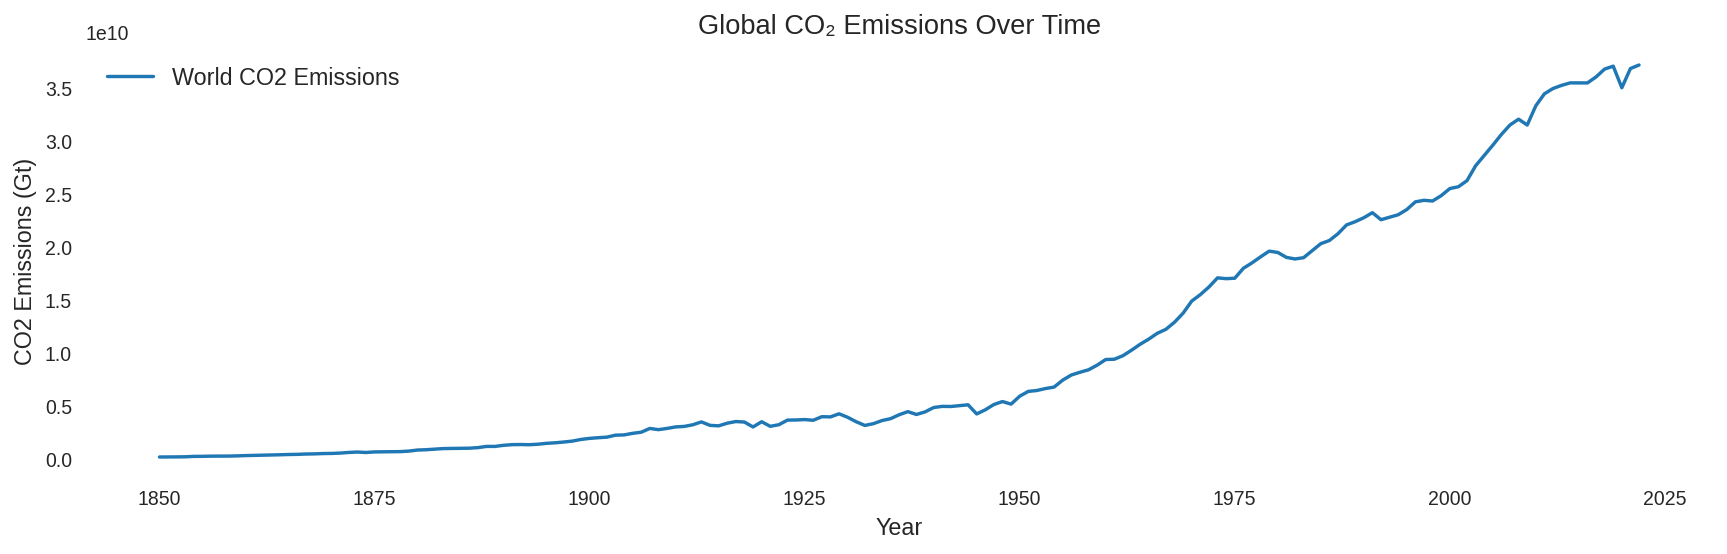

In [4]:
# Reading local data (its downloaded on local storage)
data = pd.read_csv("co2.csv")

# Filtering out the data related to the world
world_co2_df = data[data["Entity"] == 'World'][['Year','Annual CO₂ emissions']]
# Create a list 
world_co2_list = world_co2_df.values.tolist() 
# Create a numpy array 
world_co2_array =  np.array(world_co2_list)
co2_emissions = world_co2_array[100:]

# Plotting
plt.plot(co2_emissions[:,0], co2_emissions[:,1], label='World CO2 Emissions')

# Axes Labels
plt.xlabel("Year", fontsize=12)
plt.ylabel("CO2 Emissions (Gt)", fontsize=12)

# Title
plt.title("Global CO₂ Emissions Over Time", fontsize=14)

# Grid and Legend
plt.grid(True, alpha=0.7)  # Adjusting grid visibility
plt.legend(fontsize='large')

# Show Plot
plt.show()

In [5]:
co2_emissions[:,1]

array([1.9675197e+08, 1.9866811e+08, 2.0741420e+08, 2.1712043e+08,
       2.5503317e+08, 2.6010440e+08, 2.7729645e+08, 2.7993200e+08,
       2.8422515e+08, 3.0148125e+08, 3.3096260e+08, 3.4778582e+08,
       3.5448890e+08, 3.7818016e+08, 4.0772598e+08, 4.3285914e+08,
       4.4655360e+08, 4.7816074e+08, 4.9155194e+08, 5.2195420e+08,
       5.3333827e+08, 5.6689130e+08, 6.2730125e+08, 6.6648120e+08,
       6.2423250e+08, 6.7711386e+08, 6.8678020e+08, 7.0040440e+08,
       7.0597357e+08, 7.5599046e+08, 8.5391635e+08, 8.8354406e+08,
       9.3336010e+08, 9.9275360e+08, 1.0041341e+09, 1.0116371e+09,
       1.0274175e+09, 1.0787469e+09, 1.1943526e+09, 1.1946240e+09,
       1.3003624e+09, 1.3617501e+09, 1.3723965e+09, 1.3554772e+09,
       1.4030191e+09, 1.4874323e+09, 1.5363656e+09, 1.6092316e+09,
       1.6971663e+09, 1.8537092e+09, 1.9522095e+09, 2.0167444e+09,
       2.0676838e+09, 2.2541002e+09, 2.2797473e+09, 2.4273183e+09,
       2.5347330e+09, 2.8883180e+09, 2.7764408e+09, 2.8904950e

In [13]:
import pymc as pm
import theano.tensor as tt  # Use Theano tensor operations for symbolic variables
import numpy as np

# Your custom model function (now using Theano for tensor operations)
def custom_model(pc, pr, rs, rr, learning_rate, discount_factor, c):
    rd = 0
    env = RiskReward(pc, pr, rs, rr, rd)
    mae = stratAC(env=env, learning_rates=learning_rate, discount_factors=discount_factor)

    # Converting softmax strategy to work with tensor variables
    x = mae.random_softmax_strategy()

    xc = 0.999
    
    # Here x will be a tensor, we set the first element using theano's tensor operations
    x = tt.set_subtensor(x[0, 0, 0], 1 - xc)
    x = tt.set_subtensor(x[0, 0, 1], xc)
    
    xtraj, fixedpointreached = mae.trajectory(x, Tmax=173)

    # Use Theano tensor for output, so it can handle symbolic variables
    output = c * 1e10 * xtraj[:, 0, 0, 0]
    
    return output

# Build the PyMC3 model
with pm.Model() as model:
    # Priors for unknown parameters
    pc = pm.Uniform('pc', lower=0, upper=1)
    pr = pm.Uniform('pr', lower=0, upper=1)
    rs = pm.Uniform('rs', lower=0, upper=1)
    rr = pm.Uniform('rr', lower=0, upper=1)
    learning_rate = pm.Uniform('learning_rate', lower=0, upper=1)
    discount_factor = pm.Uniform('discount_factor', lower=0.9, upper=0.99)
    c = pm.Normal('c', mu=5, sigma=2)

    # Use the custom model to get the simulated output
    output = pm.Deterministic('output', custom_model(pc, pr, rs, rr, learning_rate, discount_factor, c))

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=output, sigma=10, observed=co2)

    # Inference
    trace = pm.sample(500, return_inferencedata=False)


AttributeError: partially initialized module 'theano' has no attribute 'compile' (most likely due to a circular import)

In [17]:
import pymc as pm
import aesara.tensor as at  # Use Aesara instead of Theano
import numpy as np

# Custom model function
def custom_model(pc, pr, rs, rr, learning_rate, discount_factor, c):
    rd = 0
    env = RiskReward(pc, pr, rs, rr, rd)
    mae = stratAC(env=env, learning_rates=learning_rate, discount_factors=discount_factor)

    # Use Aesara's tensor operations instead of NumPy operations
    x = mae.random_softmax_strategy()
    xc = 0.999

    x = at.set_subtensor(x[0, 0, 0], 1 - xc)
    x = at.set_subtensor(x[0, 0, 1], xc)

    xtraj, fixedpointreached = mae.trajectory(x, Tmax=173)
    output = c * 1e10 * xtraj[:, 0, 0, 0]
    
    return output

# Build the PyMC model
with pm.Model() as model:
    # Priors for unknown parameters
    pc = pm.Uniform('pc', lower=0, upper=1)
    pr = pm.Uniform('pr', lower=0, upper=1)
    rs = pm.Uniform('rs', lower=0, upper=1)
    rr = pm.Uniform('rr', lower=0, upper=1)
    learning_rate = pm.Uniform('learning_rate', lower=0, upper=1)
    discount_factor = pm.Uniform('discount_factor', lower=0.9, upper=0.99)
    c = pm.Normal('c', mu=5, sigma=2)

    # Use the custom model to get the simulated output
    output = pm.Deterministic('output', custom_model(pc, pr, rs, rr, learning_rate, discount_factor, c))

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=output, sigma=10, observed=co2)

    # Inference
    trace = pm.sample(500, return_inferencedata=False)


ValueError: setting an array element with a sequence.

In [16]:
pip install aesara


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
